<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/2-similarity-search-level-1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/2-similarity-search-level-1.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This code is part of [Chapter 4 - Building a Reverse Image Search Engine: Understanding Embeddings ](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html).

Note: In order to run this notebook on Google Colab you need to [follow these instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC) so that the local data such as the images are available in your Google Drive.

# Similarity Search

This notebook is the second among four of the follow along Jupyter notebook for chapter 4. Since we will be covering a lot of material in this notebook, we divided into three separate sections - level 1, level 2, and level 3.

In level 1, we write an indexer to index features and search for most similar features using various nearest neighbor algorithms, and explore various methods of visualizing plots.

In level 2, we benchmark the algorithms based on the time it takes to index images and locate the most similar image based on its features using the Caltech-101 dataset. We also experiment with t-SNE and PCA.

In level 3, we calculate the accuracies of the features obtained from the pretrained and finetuned models. The finetuning here follows chapter 2.

## Level 1

Here we visualize some query images represented by their standard features with their nearest neighbors 

In [ ]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Let's start by loading the files we wrote to disk in our previous notebook.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

filenames = pickle.load(open('/content/gdrive/Shared drives/2020_FDLUSA_Earth Science_Knowledge Discovery Framework/Code/Datasets/UCMerced_LandUse/filenames-ucmerced.pickle', 'rb'))
feature_list = pickle.load(open('/content/gdrive/Shared drives/2020_FDLUSA_Earth Science_Knowledge Discovery Framework/Code/Datasets/UCMerced_LandUse/features-ucmerced-resnet.pickle',
                                'rb'))
class_ids = pickle.load(open('/content/gdrive/Shared drives/2020_FDLUSA_Earth Science_Knowledge Discovery Framework/Code/Datasets/UCMerced_LandUse/class_ids-ucmerced.pickle', 'rb'))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


OSError: ignored

In [ ]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Use python's machine learning library 'scikit-learn' for finding Nearest Neighbors.

To install within the `virtualenv` use: 

`pip3 install sklearn`

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

In [ ]:
random_index = 75
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]), interpolation='lanczos')

Wait, isn’t that a duplicate? Actually, the nearest index will be the image itself because that is what is being queried.

Let’s plot the real first nearest neighbor.

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')

In [ ]:
for i in range(5):
    print(distances[0][i])

Note the distance of the query image to the first closest image is zero, again showing that the closest image to the query image is the same image.

## Experiments

Now, lets start our experiments!

In [ ]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

In [ ]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

Let us get a sense of the similarity values by looking at distance stats over the dataset.

In [ ]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  0.9896281
Max distance between all photos:  1.3203943
Median distance among most similar photos:  0.66759163


Select the amount of data you want to run the experiments on. Here we are selecting the entire dataset. To enable quicker run times you may want to select a portion of the dataset to experiment on.

In [ ]:
# selected_features = feature_list[:]
# selected_class_ids = class_ids[:]
# selected_filenames = filenames[:]

selected_features = feature_list[:1000]
selected_class_ids = class_ids[:1000]
selected_filenames = filenames[:1000]

Alternatively, for ease of illustration and speed we can simply pick a thousand image samples to plot the t-SNE results. 

```
selected_features = feature_list[7000:8000]
selected_class_ids = class_ids[7000:8000]
selected_filenames = filenames[7000:8000]
```
Note: It is important to run the entire dataset, if you wish to benchmark the entire dataset.

The t-SNE algorithm is useful for visualizing high dimensional data.

In [ ]:
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.194s...
[t-SNE] Computed neighbors for 1000 samples in 5.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.236148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.155384
[t-SNE] KL divergence after 1000 iterations: 0.560917
t-SNE done! Time elapsed: 11.48965311050415 seconds


### Plot a scatter plot from the generated t-SNE results

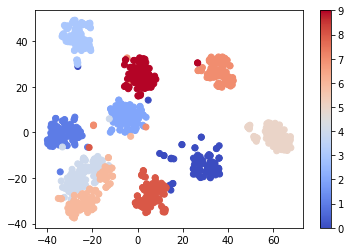

In [ ]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()
# To save the plot in a high definition format i.e. PDF, uncomment the following line:
#plt.savefig('results/' + str(ADD_NAME_HERE)+'.pdf', format='pdf', dpi=1000)

Now we write a helper function to plot images in 2D for t-SNE.

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data


def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

The following is a helper function to render a t-SNE plot.

In [ ]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

#### 1.3 Visualize the patterns in the images using t-SNE

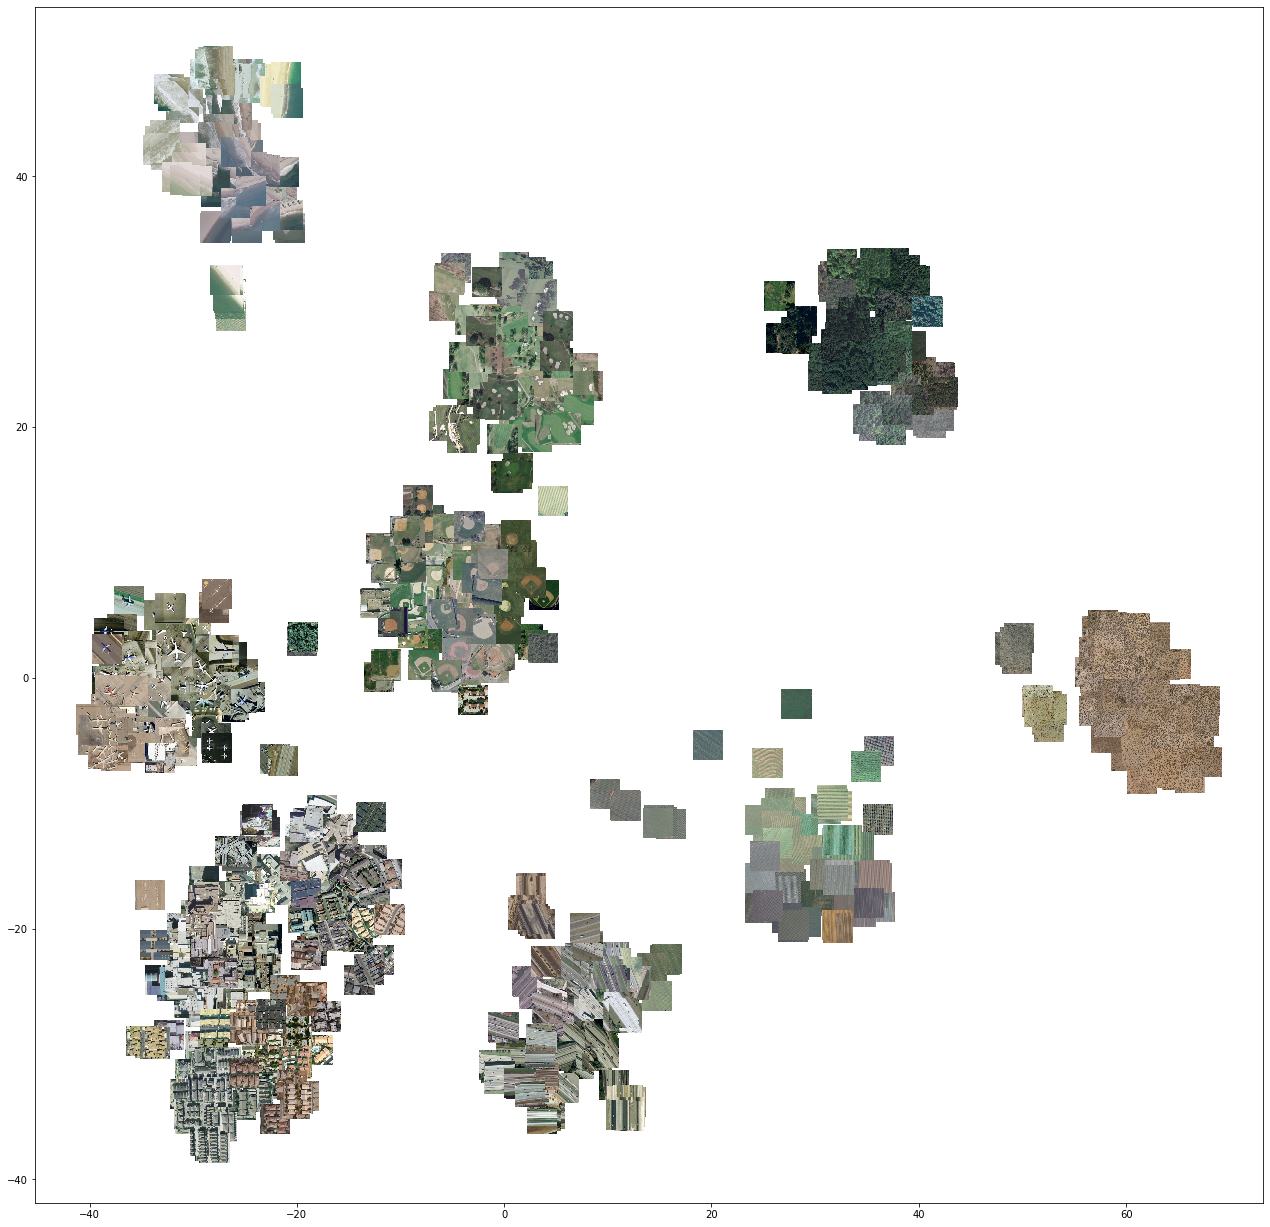

In [ ]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

The `show_tsne` function piles images one on top of each other, making it harder to discern the patterns as the density of images is high. To help visualize the patterns better, we write another helper function `tsne_to_grid_plotter_manual` that spaces the images evenly.

In [ ]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()

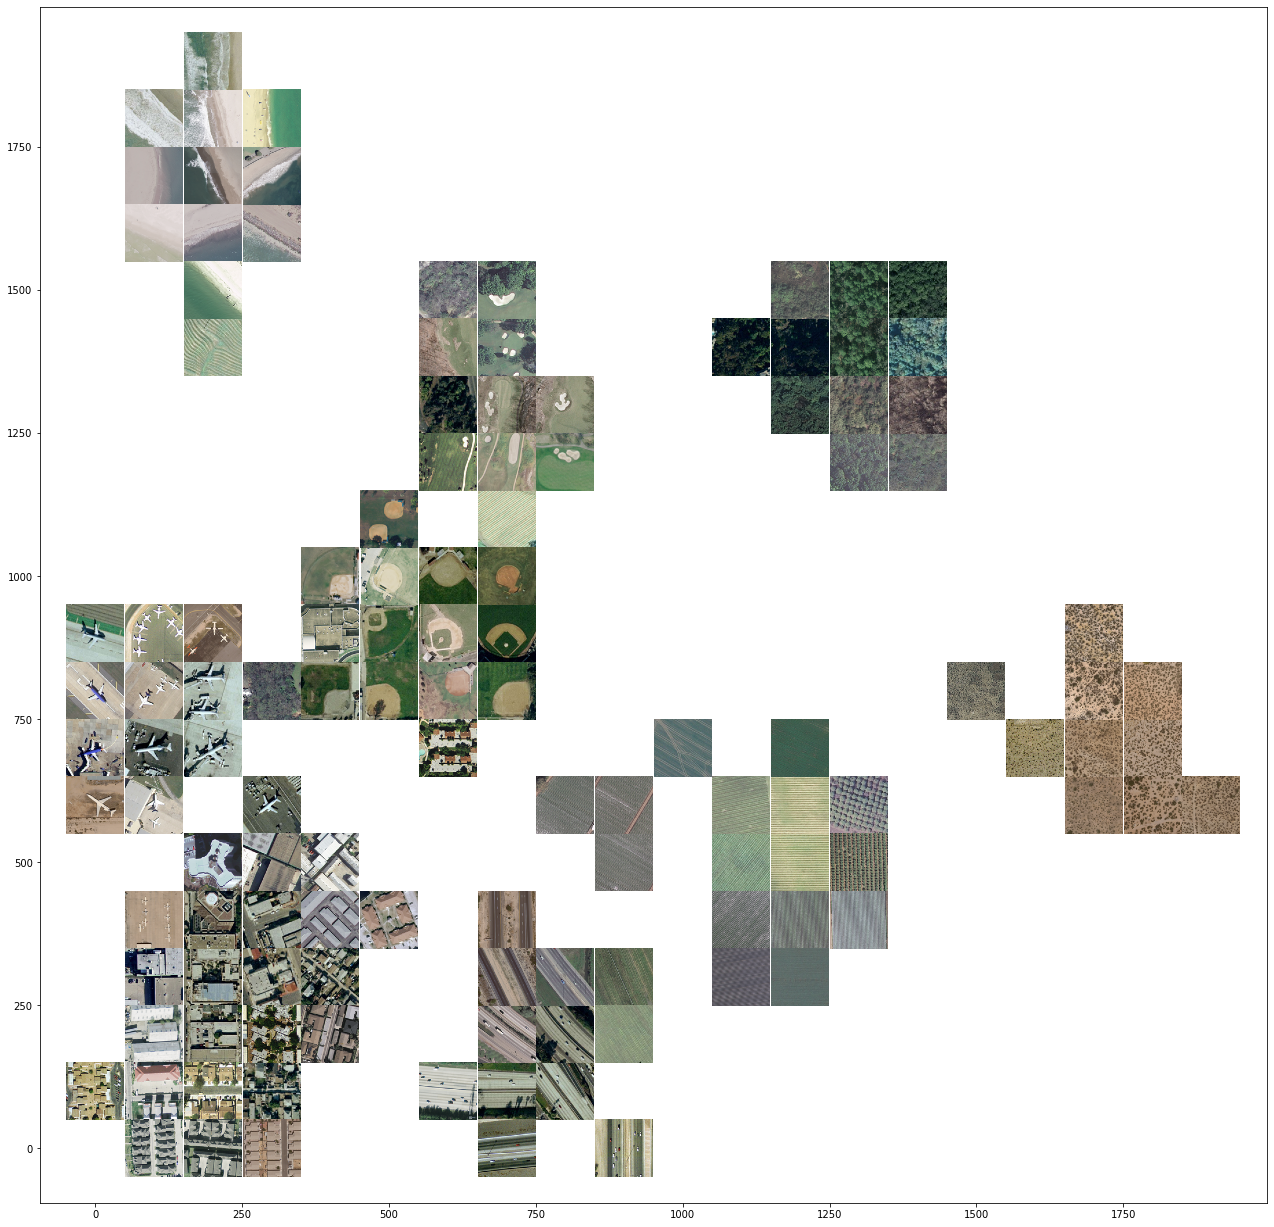

In [ ]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)

### PCA

We will perform [Principal Component Analysis (PCA)](https://asaip.psu.edu/submitted-papers/2013/liii.-on-lines-and-planes-of-closest-fit-to-systems-of-points-in-space) over the features using `100` feature dimensions.

In [ ]:
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list_compressed)
distances, indices = neighbors.kneighbors([feature_list_compressed[0]])

#### Visualize some query images with their nearest neighbors

In [ ]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list_compressed[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

Again, for speed we pick a few thousand image samples. (You can choose to benchmark the entire dataset by removing the upper limit.)

In [ ]:
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

time_start = time.time()
tsne_results = TSNE(n_components=2, verbose=1,
                    metric='euclidean').fit_transform(selected_features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.023s...
[t-SNE] Computed neighbors for 2100 samples in 1.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.198073
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.000656
[t-SNE] KL divergence after 1000 iterations: 0.897565
t-SNE done! Time elapsed: 16.162320137023926 seconds


#### Plot a scatter plot from the generated t-SNE results

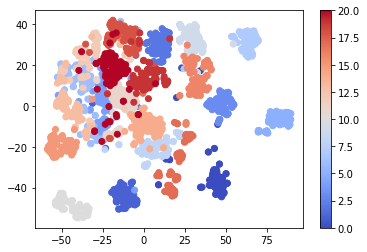

In [ ]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

#### Visualize the patterns in the images using t-SNE

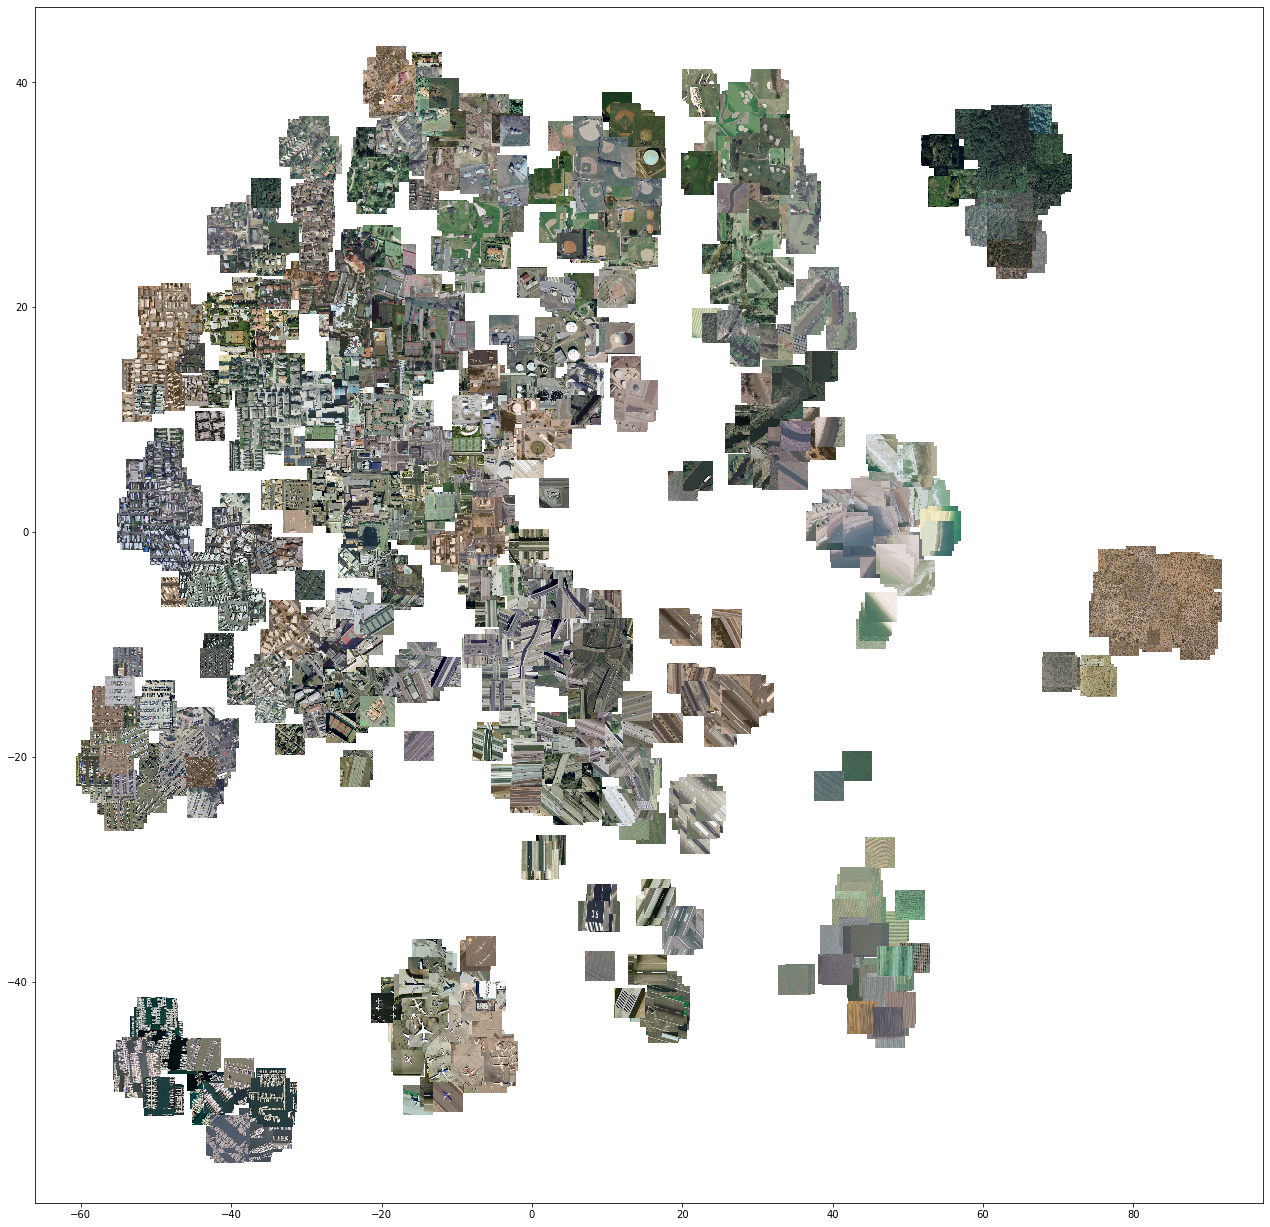

In [ ]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [ ]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)